Assignment Overview
-----------------------------------

### 6.1 Assignment: Build a Baseline Model

### Objective:
You will enhance the classification model previously built in the session to predict loan defaults using the Lending Club dataset. Please use the 100k row sample as starting point for your model.  

#### Part 1 - Mandatory
Build a second model, `model_2`:
- selecting additional variables
- performing feature engineering (feel free to use features engineered previously)
- performing cross-validation 
- dealing with class imbalance 
- any additional techniques you would like to add to improve your model, at your discretion 

Compare it to `model` by using the evaluation metrics covered in this session.

#### Part 2 - Optional
As a data scientist working for the business, your objective is to **minimize the average cost of default** and **maximize the average income on loans**. Optimise `model_2` on this basis, leveraging a **custom loss function** (see 7.2 below) and considering the **following information on the cost of misclassifying** unseen observations:
##### Misclassification cost, and importance of False Positives and False Negatives:
-   **False Positives (FP)**: Predicting a loan as default when it is not. This can lead to lost opportunities for the lender since a potentially profitable loan is denied. Given the **FP_cost = 100**, the cost is relatively low, but it can accumulate over multiple instances.

-   **False Negatives (FN)**: Predicting a loan as non-default when it actually defaults. This is much more severe because it results in financial loss to the lender. Given the **FN_cost = 1000**, the cost here is much higher, reflecting the significant impact of a loan defaulting when it was predicted otherwise.


#### Part 3 - Optional
The business also wants you to do a PoC to see if they can predict `loan_amnt` based on the following features (feel free to use additional ones if you would like): `emp_length`,`home_ownership`, `annual_inc`.
Build a brand new regression model, `reg_model`, leveraging `LinearRegression` from `sklearn.linear_model` ( see [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html))


### Tips:
-   **Feature Engineering**: Explore new features that might improve model performance. You may want or need to use some of the techniques covered in session 3.
-   **Cross-Validation**: Implement cross-validation to ensure your model does not overfit to the training data.
-   **Threshold Adjustment**: Consider adjusting the decision threshold to balance false positives and false negatives based on the associated costs.

### Deliverables:

-   A Jupyter Notebook containing:
    -   Detailed explanations of feature selection and engineering.
    -   Cross-validation implementation.
    -   Final model performance evaluation using custom loss metrics (FP_cost and FN_cost).
    -   Part 2 (optional): Custom loss function implementation and loss optimisation



### Set up

In [863]:
python_material_folder_name = "python-material"

#### Import libraries

In [3]:
#Import library
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Check if in Google Colab environment
try:
    from google.colab import drive
    # Mount drive
    drive.mount('/content/drive')
    # Set up path to Python material parent folder
    path_python_material = rf"drive/MyDrive/{python_material_folder_name}"
        # If unsure, print current directory path by executing the following in a new cell:
        # !pwd
    IN_COLAB = True
except:
    IN_COLAB = False
    # If working locally on Jupyter Notebook, parent folder is one folder up (assuming you are using the folder structure shared at the beginning of the course)
    path_python_material = "/Users/hisay/Desktop/Courses/DSFinance/Data_Science_in_Finance_Resources/python-material"

# Read data that was exported from previous session
df = pd.read_csv(f"{path_python_material}/data/1-raw/lending-club-2007-2020Q3/Loan_status_2007-2020Q3-100ksample.csv")
df.head()

#Read the dictionary file
df_dictionary = pd.read_excel(f"{path_python_material}/data/1-raw/lending-club-2007-2020Q3/LCDataDictionary.xlsx")

# Convert to Markdown format
from IPython.display import Markdown
markdown_table = df_dictionary.to_markdown(index=False)  
#print("\n Here is the Dictionary for the list of the variables \n")
#display(Markdown(markdown_table))  # Display as Markdown 

### Removal of unwanted columns



In [8]:
#Drop the Unnamed columns, just for the convenience
list_to_drop = ['Unnamed: 0.1', 'Unnamed: 0']#YOUR CODE HERE
df_new = df.drop(list_to_drop, axis= 1)
df_new.shape

(100000, 141)

In [10]:
#Display the updated datafranm
df_new.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,167338079,4000.0,4000.0,4000.0,36 months,13.08%,134.93,B,B5,cashier,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,71016917,24000.0,24000.0,24000.0,60 months,9.16%,500.07,B,B2,ABM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,39589826,5000.0,5000.0,5000.0,36 months,10.49%,162.49,B,B3,driver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,134798709,24000.0,24000.0,24000.0,60 months,11.05%,522.42,B,B4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,127097355,14000.0,14000.0,14000.0,60 months,13.59%,322.79,C,C2,Shipping Clerk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


### <span style = 'color: BLUE'> Exploratory data analysis

Here, I analyze the loan status to categorize the defaulter, non-defaulters and others.

*<span style = 'color: BLUE'>Useful definitions:*  
- *Defaulted Loan: A loan is considered in default when the borrower fails to make the required payments as agreed in the loan contract. Default typically occurs after missing several payments (usually 90 to 180 days, depending on the type of loan and lender policies).*
- *A loan is charged off when the lender writes off the loan as a bad debt on their financial statements, recognizing it as a loss. This typically happens after the loan has been in default for a significant period, often around 180 days.*

In [13]:
#The loan status
df_new.loan_status.value_counts()

loan_status
Fully Paid                                             51189
Current                                                35294
Charged Off                                            12384
Late (31-120 days)                                       535
In Grace Period                                          329
Late (16-30 days)                                         90
Does not meet the credit policy. Status:Fully Paid        69
Issued                                                    63
Does not meet the credit policy. Status:Charged Off       33
Default                                                   14
Name: count, dtype: int64

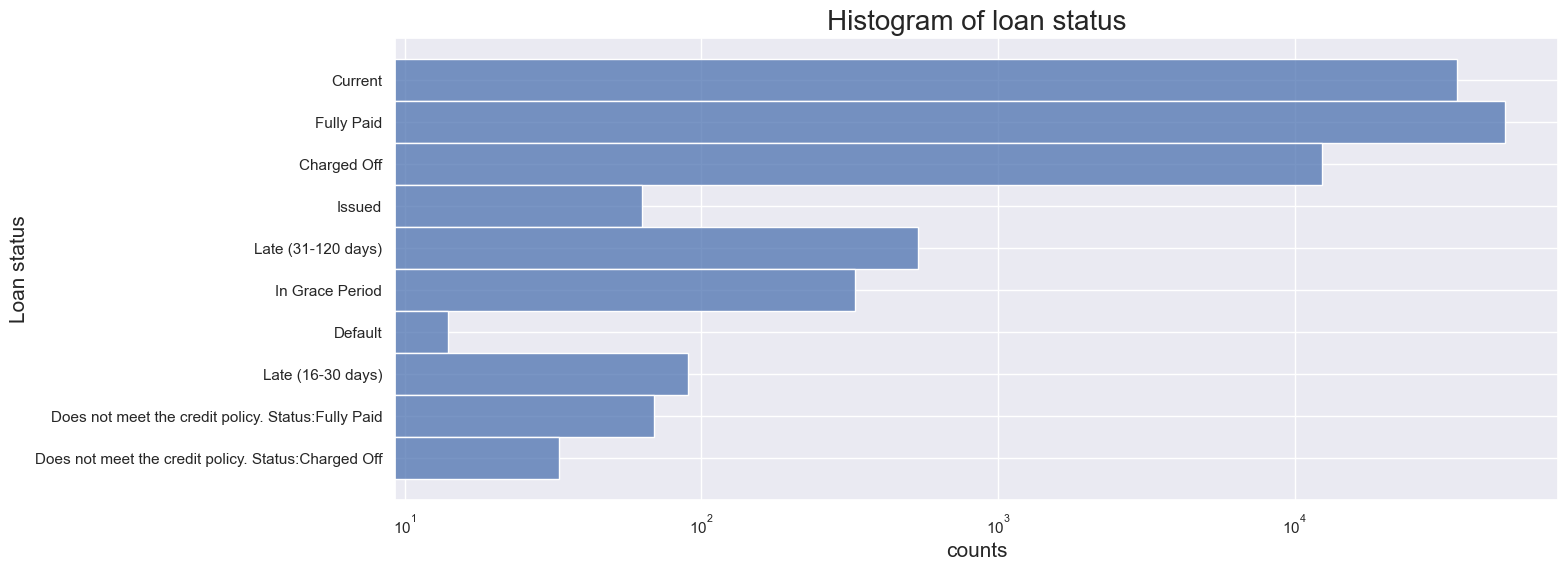

In [15]:
#Histogram plot
sns.set(rc={'figure.figsize':(15,6)})
sns.histplot(y = df['loan_status'], bins = 20)
plt.xscale('log')
plt.title("Histogram of loan status", fontsize=20)
plt.xlabel("counts", fontsize=15)
plt.ylabel("Loan status", fontsize=15);
plt.show()

Text(0, 0.5, 'Loan Status')

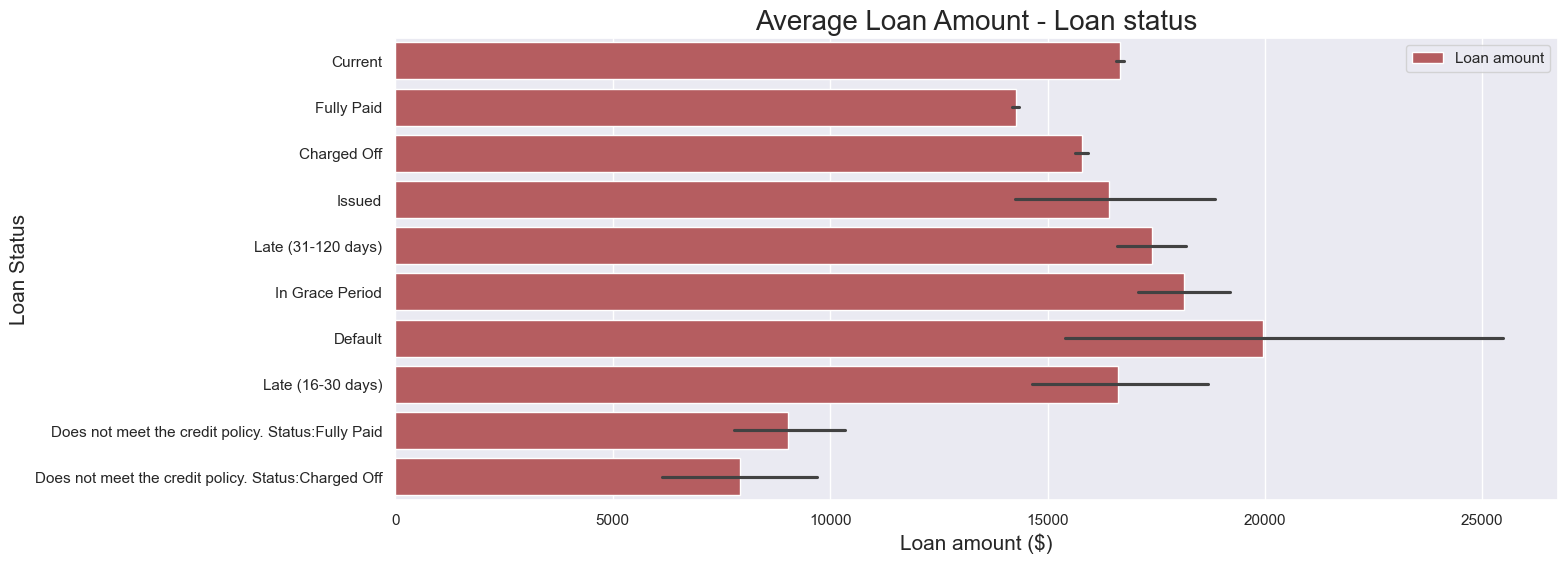

In [16]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'loan_amnt', y = 'loan_status', data = df_new, label = "Loan amount", color = "r")
plt.title("Average Loan Amount - Loan status", fontsize=20)
plt.xlabel("Loan amount ($)", fontsize=15)
plt.ylabel("Loan Status", fontsize=15)

The plot clearly indicates that defaults are associated with higher loan amounts, typically exceeding 20,000 USD. Conversely, loans under 8,000 USD tend to fall into the "Does not meet credit policy" category, while those between 8,000 USD and 17,000 USD are spread across the remaining categories.

Text(0, 0.5, 'Loan Status')

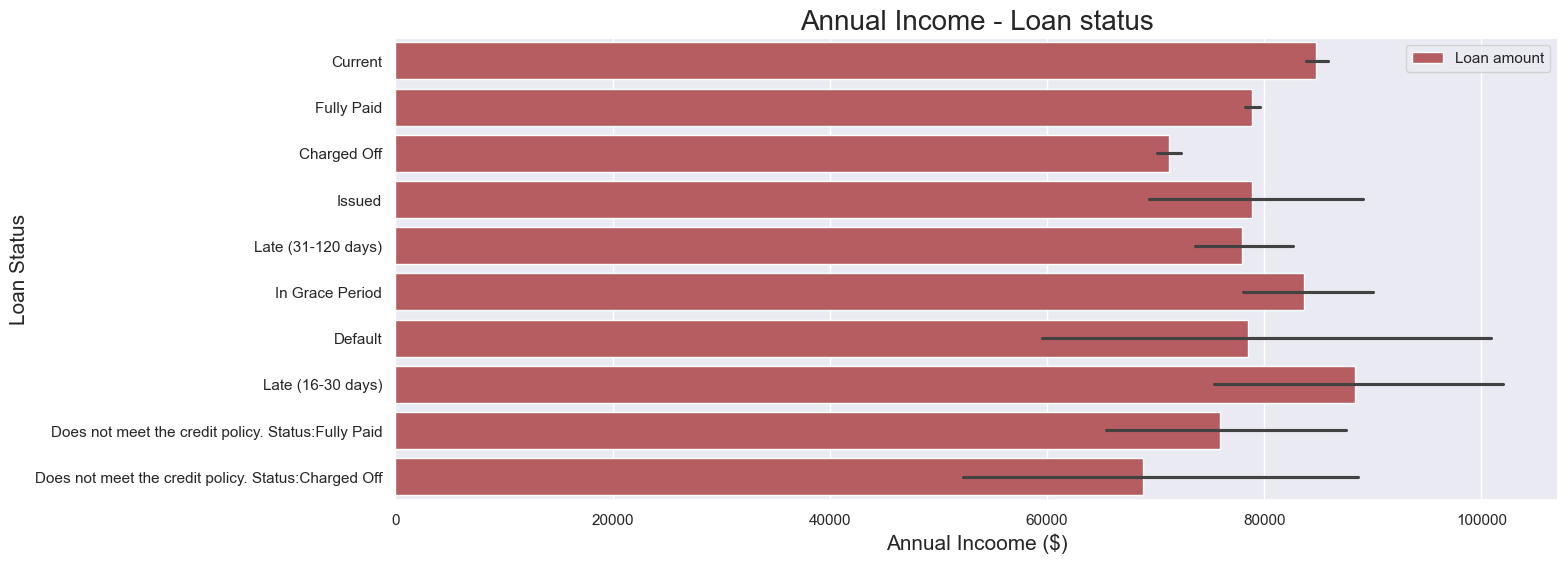

In [19]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'annual_inc', y = 'loan_status', data = df_new, label = "Loan amount", color = "r")
plt.title("Annual Income - Loan status", fontsize=20)
plt.xlabel("Annual Incoome ($)", fontsize=15)
plt.ylabel("Loan Status", fontsize=15)

We will break this plot later. 

Let's check whether type of application (individual or joint application) has any dependence on the loan amount.

In [22]:
#application type
num_unique = df_new["application_type"].unique()
print(num_unique)

['Individual' 'Joint App']


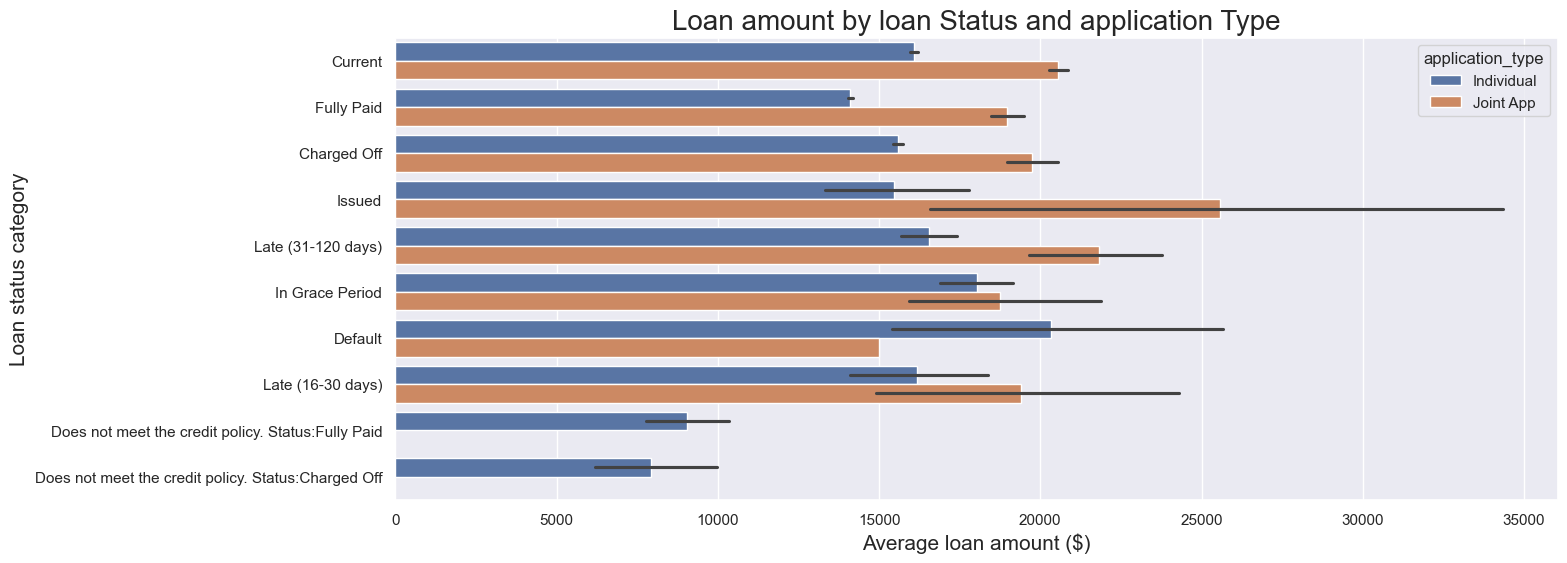

In [25]:
sns.set(rc={'figure.figsize': (15, 6)})
sns.barplot(y='loan_status', 
            x='loan_amnt', 
            hue='application_type', 
            data=df_new)
plt.title("Loan amount by loan Status and application Type", fontsize=20)
plt.ylabel("Loan status category", fontsize=15)
plt.xlabel("Average loan amount ($)", fontsize=15)
plt.show()

The higher loan was given to the joint application type applicant that's apparent. Lets see their density in the violin plot:

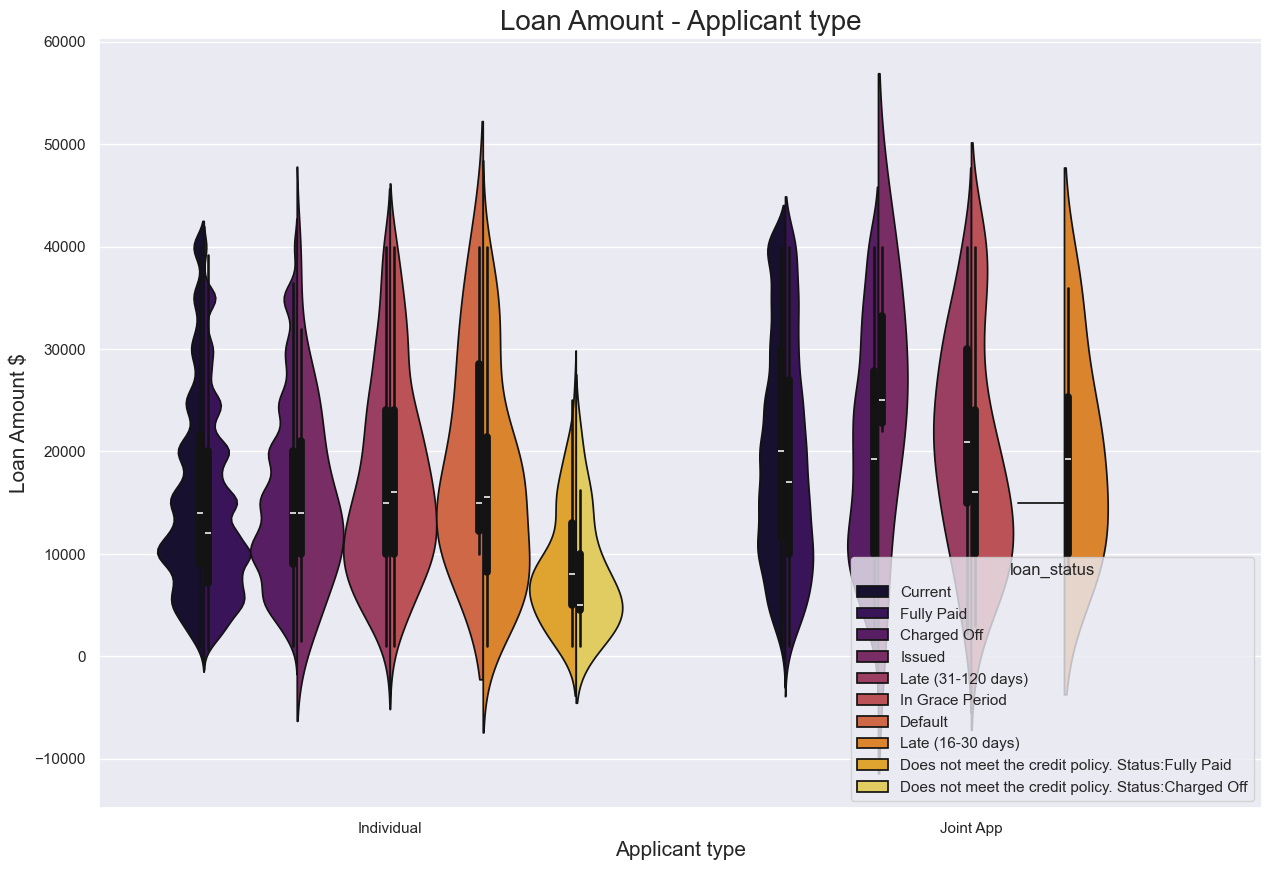

In [28]:
sns.set(rc={'figure.figsize':(15,10)})
sns.violinplot(x="application_type",y="loan_amnt",data=df_new, 
               hue="loan_status", split=True,palette='inferno')
plt.title("Loan Amount - Applicant type", fontsize=20)
plt.xlabel("Applicant type", fontsize=15)
plt.ylabel("Loan Amount $", fontsize=15);

Some negative values of numeric data in the `loan amounts` were  detected, which requires some data cleaning at a later stage. `Defaults` are less with Joint type applicants.

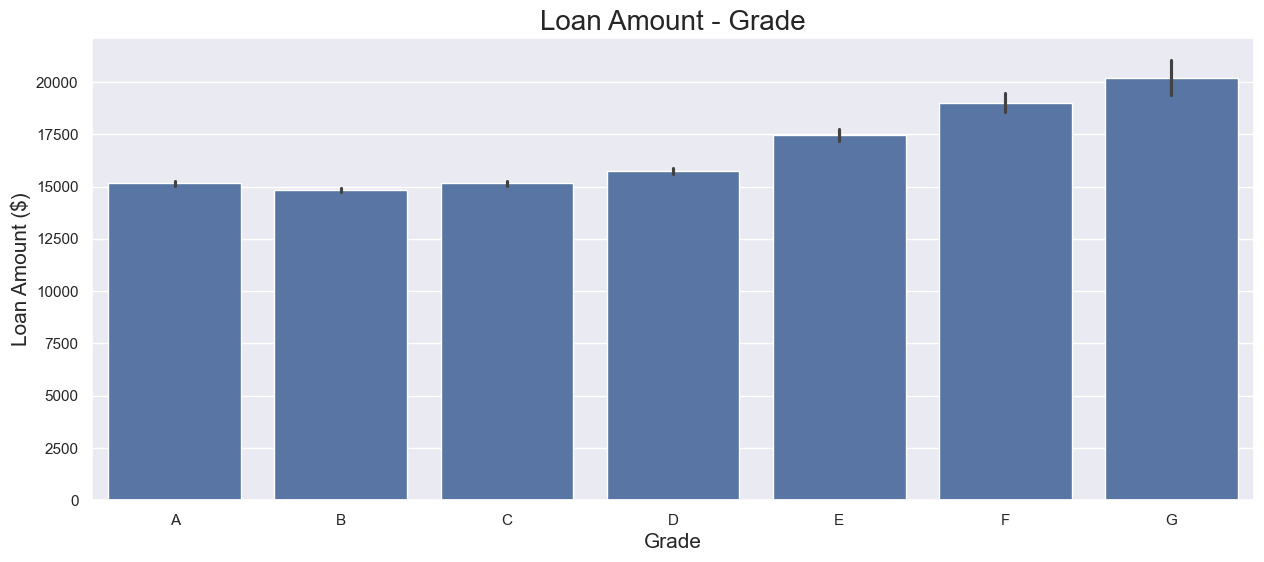

In [32]:
#Let's study now loan grades
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'grade', y = 'loan_amnt', data = df_new, order="ABCDEFG")
plt.title("Loan Amount - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Loan Amount ($)", fontsize=15);

**Next, I combine the small-case and large-case labels in the data, as they are currently treated as separate labels.**

The column `grades` is assigned based on the average loan amount. For example `A` - 15000 \$ to `G` - 20000$, which shows that the highest grade equates to the greater loan amount. Now let's check how `interest rate` and `term` relates to the `grade`.

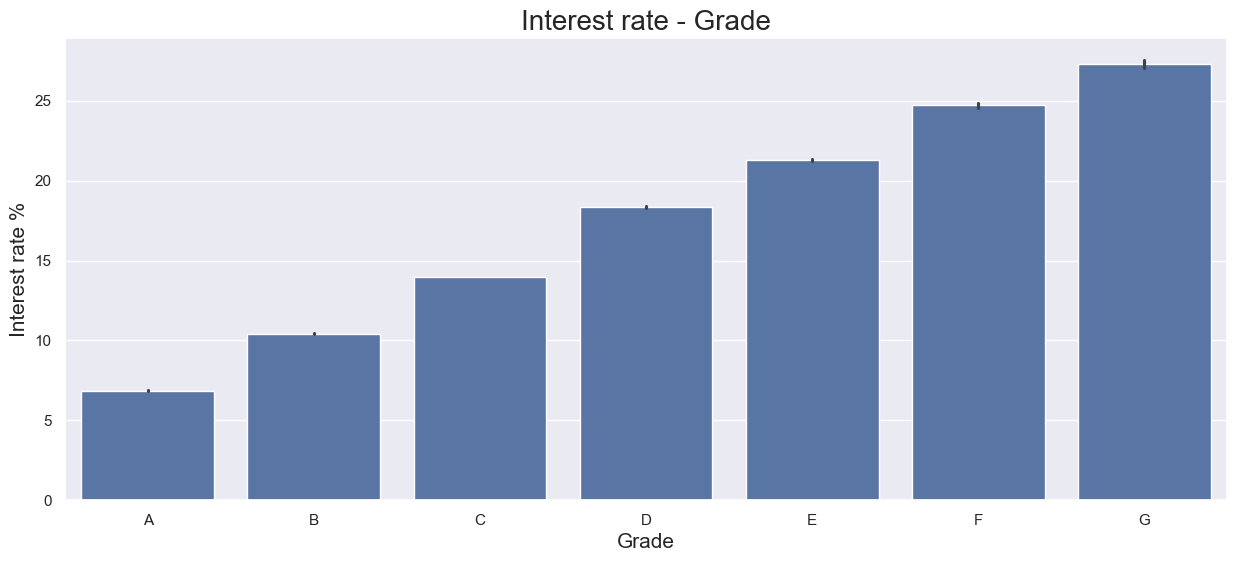

In [34]:
#I first chnaged the alpha numeric columns to a numeric columns
df_new['term_numeric'] = df_new['term'].str.extract(r'(\d+)').astype(int)
df_new['int_rate_numeric'] = df_new['int_rate'].str.extract(r'(\d+)').astype(int)

#sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'grade', y = 'int_rate_numeric', data = df_new, order="ABCDEFG")
plt.title("Interest rate - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Interest rate %", fontsize=15);

It's apparent that the `Grade` is given based on the interest rate. Higher the interest rate, the higher the grade.

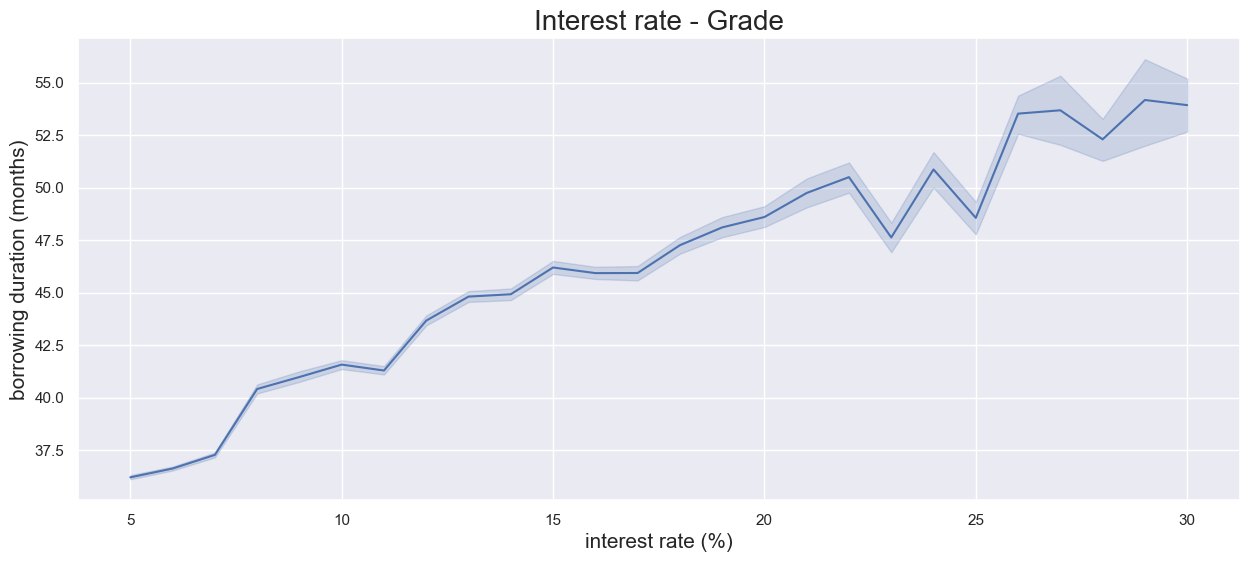

In [36]:
#sns.set(rc={'figure.figsize':(15,6)})
sns.lineplot(x = 'int_rate_numeric', y = 'term_numeric', data = df_new)
plt.title("Interest rate - Grade", fontsize=20)
plt.xlabel("interest rate (%)", fontsize=15)
plt.ylabel("borrowing duration (months)", fontsize=15);

This suggests that, on average, borrowers with longer loan durations are assigned higher interest rates.

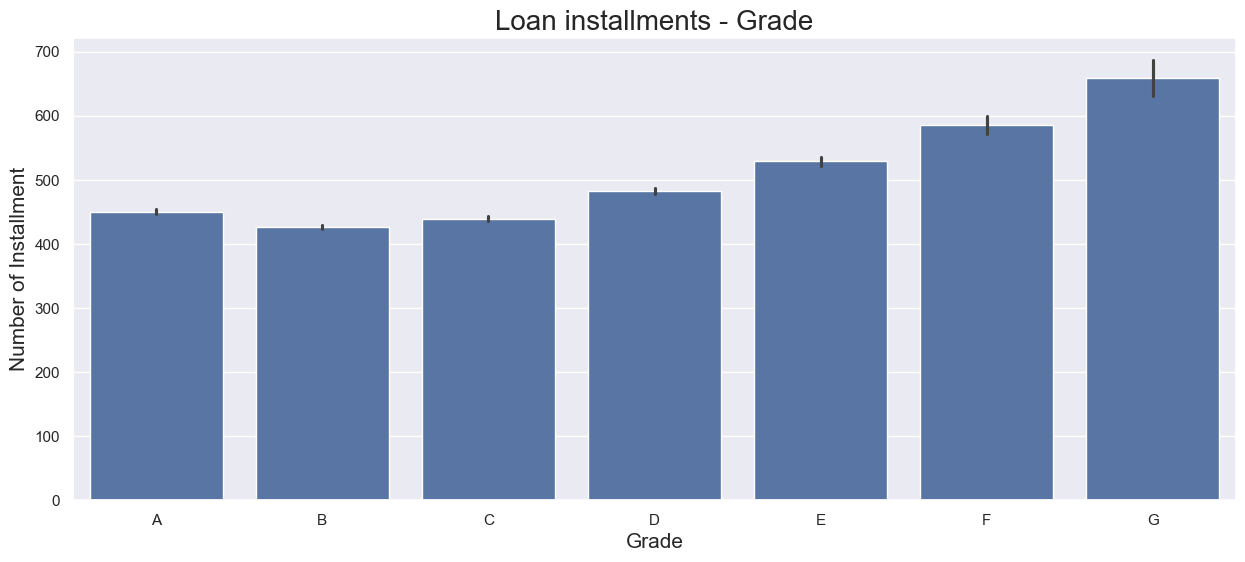

In [39]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'grade', y = 'installment', data = df_new, order="ABCDEFG")
plt.title("Loan installments - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Number of Installment", fontsize=15);

Therefore, the number of installements are greater for higher loan which G grade.

### <span style = 'color: BLUE'> 2. Feature selection

Based on our exploratory data analysis, let's select a few important variables from the dataset for our analysis. 

<span style="color:BLUE"> **Most Important Variables for Loan Approval**
- `id`$\rightarrow$ ID number for borrower
- `annual_inc` $\rightarrow$  Self-reported annual income
- `loan_amnt` $\rightarrow$  Loan amount requested
- `loan_status` $\rightarrow$  Loan status (Fully Paid, Charged Off, Late, Default)
- `term` $\rightarrow$  Duration for loan repayment (36 or 60 months) (converted to numeric)
- `application_type` $\rightarrow$  Application type (Individual type or joint type)
- `int_rate`$\rightarrow$ interest rate (converted to numeric)
- `grades` $\rightarrow$ loan grades
- `installment` $\rightarrow$ The monthly payment amount.
- `(fico_range_high + fico_range_low)/2` $\rightarrow$  FICO credit score  - we will create them for our analysis

---
<span style='color:BLUE'>Some other variables (may be important):
- `pub_rec_bankruptcies` $\rightarrow$  Number of bankruptcies recorded
- `home_ownership` $\rightarrow$  MORTGAGE, RENT, OWN (Financial status)
- `out_prncp_inv` $\rightarrow$  Remaining outstanding principal
- `purpose` $\rightarrow$  Reason for loan (e.g., credit card debt consolidation, home improvement)
- `recoveries` $\rightarrow$ Amount recovered from charged-off loans.
- `emp_length` $\rightarrow$ Employment length



These variables help **assess risk**, determine the **borrower’s ability to repay**, and predict **loan performance**.

## <span style = 'color: BLUE'> Task 3

In [42]:
#Make a clean data frame with the most important columns
df_clean = df_new[["id", "annual_inc","loan_amnt", "term_numeric",
                   "int_rate_numeric", "home_ownership", "emp_length"]]

df_clean.head()         

,id,annual_inc,loan_amnt,term_numeric,int_rate_numeric,home_ownership,emp_length
0,167338079,48000.0,4000.0,36,13,MORTGAGE,10+ years
1,71016917,57000.0,24000.0,60,9,RENT,6 years
2,39589826,55000.0,5000.0,36,10,MORTGAGE,10+ years
3,134798709,43500.0,24000.0,60,11,MORTGAGE,NaN
4,127097355,48000.0,14000.0,60,13,MORTGAGE,10+ years


In [96]:
df_selected = df_new[["loan_amnt", "annual_inc", "home_ownership", "emp_length"]]
print("Display the number of unique categories in the home_ownership:")
print(df_selected["home_ownership"].value_counts())
print("\n----")
print("Display the information of datypes:")
df_selected.info()
print("\n----")
print("Display the number of nulls in the respective columns:")
print(df_selected.isnull().sum())

Display the number of unique categories in the home_ownership:
home_ownership
MORTGAGE    49149
RENT        39472
OWN         11238
ANY           125
OTHER          12
NONE            4
Name: count, dtype: int64

----
Display the information of datypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   loan_amnt       100000 non-null  float64
 1   annual_inc      100000 non-null  float64
 2   home_ownership  100000 non-null  object 
 3   emp_length      93050 non-null   object 
dtypes: float64(2), object(2)
memory usage: 3.1+ MB

----
Display the number of nulls in the respective columns:
loan_amnt            0
annual_inc           0
home_ownership       0
emp_length        6950
dtype: int64


In [143]:
#We remove all the rows with the missing values or nan
df_selected_new = df_selected.dropna(axis = 0)
df_selected_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93050 entries, 0 to 99998
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loan_amnt       93050 non-null  float64
 1   annual_inc      93050 non-null  float64
 2   home_ownership  93050 non-null  object 
 3   emp_length      93050 non-null  object 
dtypes: float64(2), object(2)
memory usage: 3.5+ MB


In [145]:
#Now lets convert the employment duration into a numeric value
df_selected_new["emp_length_numeric"] = df_selected_new["emp_length"].str.extract(r'(\d+)').astype(int)
df_selected_new.head()

/var/folders/w1/57hxdrg95bz5z53xtdj70dv00000gn/T/ipykernel_2484/1562210799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_new["emp_length_numeric"] = df_selected_new["emp_length"].str.extract(r'(\d+)').astype(int)


,loan_amnt,annual_inc,home_ownership,emp_length,emp_length_numeric
0,4000.0,48000.0,MORTGAGE,10+ years,10
1,24000.0,57000.0,RENT,6 years,6
2,5000.0,55000.0,MORTGAGE,10+ years,10
4,14000.0,48000.0,MORTGAGE,10+ years,10
5,4000.0,46000.0,RENT,10+ years,10


In [161]:
#We convert the categorical variable (home_ownership), before that we consider the column with the mortgagae, rent or own
df_1 = df_selected_new[df_selected_new["home_ownership"].isin(["OWN", "MORTGAGE", "RENT"])]
df_1.head()

,loan_amnt,annual_inc,home_ownership,emp_length,emp_length_numeric
0,4000.0,48000.0,MORTGAGE,10+ years,10
1,24000.0,57000.0,RENT,6 years,6
2,5000.0,55000.0,MORTGAGE,10+ years,10
4,14000.0,48000.0,MORTGAGE,10+ years,10
5,4000.0,46000.0,RENT,10+ years,10


In [207]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_1[["home_ownership"]])
encoded_df = pd.DataFrame(encoded_features, 
                          columns=encoder.get_feature_names_out(['home_ownership'])).astype(int)

# Merge the encoded features with the rest of the data
df_encoded = pd.concat([df_1.drop(columns=['home_ownership']), encoded_df], axis=1)
df_encoded.head()

,loan_amnt,annual_inc,emp_length,emp_length_numeric,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT
0,4000.0,48000.0,10+ years,10.0,1.0,0.0,0.0
1,24000.0,57000.0,6 years,6.0,0.0,0.0,1.0
2,5000.0,55000.0,10+ years,10.0,1.0,0.0,0.0
4,14000.0,48000.0,10+ years,10.0,0.0,0.0,1.0
5,4000.0,46000.0,10+ years,10.0,1.0,0.0,0.0


### <span style = 'color: BLUE'> Feautre selection



In [237]:
features = ['annual_inc', 'emp_length_numeric', 'home_ownership_MORTGAGE', 'home_ownership_RENT', 'home_ownership_OWN']
X = df_encoded[features]
y = df_encoded['loan_amnt']
X1 = X.dropna()
y1 = y.loc[X1.index]  # Align y with X_clean
print("Shape after dropping NaNs:", X1.shape)

Shape after dropping NaNs: (86388, 5)


In [239]:
X1.head()

,annual_inc,emp_length_numeric,home_ownership_MORTGAGE,home_ownership_RENT,home_ownership_OWN
0,48000.0,10.0,1.0,0.0,0.0
1,57000.0,6.0,0.0,1.0,0.0
2,55000.0,10.0,1.0,0.0,0.0
4,48000.0,10.0,0.0,1.0,0.0
5,46000.0,10.0,1.0,0.0,0.0


### <span style ='color: BLUE'> 3. Model development

In [241]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1,y1, 
                                                    test_size = 0.2, random_state=42)

for dframe in [X_train, X_test, y_train, y_test]:
    print(f"Shape: {dframe.shape}")

Shape: (69110, 5)
Shape: (17278, 5)
Shape: (69110,)
Shape: (17278,)


In [243]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [245]:
# Predict on the test set
predictions = model.predict(X_test)
predictions

array([17585.94839928, 15489.77972801, 13799.4625587 , ...,
       15297.39031183, 16195.55848052, 15296.63097867])

### 4. <span style = 'color: BLUE'>Model evaluation

In [251]:
from sklearn.metrics import mean_squared_error, r2_score
# Evaluate the model
y_pred = predictions
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance:")
print("MSE:", mse)
print("R²:", r2)


Linear Regression Performance:
MSE: 85913435.79516737
R²: 0.0545079111364013


In [261]:
# ---------------------
# Create and Evaluate a Baseline Model using Dummy Regressor from scikit learn
# ---------------------
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

mse_dummy = mean_squared_error(y_test, y_dummy)
r2_dummy = r2_score(y_test, y_dummy)

print("\nDummy Regressor Performance:")
print("MSE:", mse_dummy)
print("R²:", r2_dummy)

# ---------------------
# Compare the Results
# ---------------------
if mse < mse_dummy:
    print("\nThe Linear Regression model outperforms the Dummy Regressor in terms of MSE.")
else:
    print("The Linear Regression model does not have a better R² score than the Dummy Regressor.")



Dummy Regressor Performance:
MSE: 90886403.87367216
R²: -0.00022045507173928947

The Linear Regression model outperforms the Dummy Regressor in terms of MSE.
